#Import drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import library

In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
input_path = "/content/drive/MyDrive/lfw2/lfw/"

#Using ResNet 50 to train the model

In [4]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'train', data_transforms['train']),
    'validation': 
    datasets.ImageFolder(input_path + 'validation', data_transforms['validation'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=64,
                                shuffle=True,
                                num_workers=0),  
    'validation':
    torch.utils.data.DataLoader(image_datasets['validation'],
                                batch_size=64,
                                shuffle=False,
                                num_workers=0)  
}

# Use Gpu

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device
# device = 'cpu'

device(type='cuda', index=0)

In [146]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 11498),
               nn.ReLU(inplace=True),
               nn.Linear(11498, 5749)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [148]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            cont = 0
            for inputs, labels in dataloaders[phase]:
                # if cont % 20 == 0:
                print(cont/20, end=' ')
                cont += 1
                # print(inputs)
                # print(labels)
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

# Train the model 

In [ ]:
model_trained = train_model(model, criterion, optimizer, num_epochs=100)

#Save and load model

In [29]:
torch.save(model_trained.state_dict(), '/content/drive/MyDrive/lfw2/weights.h5')

In [6]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 11498),
               nn.ReLU(inplace=True),
               nn.Linear(11498, 5749)).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/lfw2/weights.h5'))

<All keys matched successfully>

# Get feature vector from each image
Which is the last layer, the fully connected layer [2]

In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image
 
layer = model._modules.get('fc')[2]
 
model.eval()
 
scaler = transforms.Resize((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name): 
    img = Image.open(image_name) 
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0)) 
    my_embedding = torch.zeros(5749) 
    def copy_data(m, i, o): 
        my_embedding.copy_(o.data.reshape(o.data.size(1))) 
    h = layer.register_forward_hook(copy_data) 
    t_img = t_img.cuda() 
    model(t_img) 
    h.remove() 
    return my_embedding.numpy()
print(get_vector(input_path + "train/George_W_Bush/George_W_Bush_0002.jpg"))

[ -87.718155 -123.74492   -79.09356  ...  -99.37766   -76.49476
  -67.25096 ]


#Here we save all the image path to img_path, and save all the feature vector for each image to feature_vector_space

In [21]:
img_path = []
feature_vector_space = []
from os import listdir
from os.path import isfile, join
c = 0
for f in listdir(input_path+'train'):
  for i in listdir(input_path+'train/'+ f):
    c += 1
    if c%20 == 0:
      print(c, end=' ')
    img_path.append(f + '/' + i) 
    feature_vector_space.append(get_vector(input_path+'train/'+ f + '/' + i))
print(img_path[:10])
print(feature_vector_space[:10])

20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 2000 2020 2040 2060 2080 2100 2120 2140 2160 2180 2200 2220 2240 2260 2280 2300 2320 2340 2360 2380 2400 2420 2440 2460 2480 2500 2520 2540 2560 2580 2600 2620 2640 2660 2680 2700 2720 2740 2760 2780 2800 2820 2840 2860 2880 2900 2920 2940 2960 2980 3000 3020 3040 3060 3080 3100 3120 3140 3160 3180 3200 3220 3240 3260 3280 3300 3320 3340 3360 3380 3400 3420 3440 3460 3480 3500 3520 3540 3560 3580 3600 3620 3640 3660 3680 3700 3720 3740 3760 3780 3800 3820 3840 3860 3880 3900 3920 3940 3960 3980 4000 4020 4040 4060 4080 4100 4120 4140 4160 4180 4200 422

In [72]:
img_path = [] 
from os import listdir
from os.path import isfile, join
c = 0
for f in listdir(input_path+'train'):
  for i in listdir(input_path+'train/'+ f):
    c += 1
    if c%20 == 0:
      print(c, end=' ')
    img_path.append(f + '/' + i)  

20 40 60 80 100 120 140 160 180 200 220 240 260 280 300 320 340 360 380 400 420 440 460 480 500 520 540 560 580 600 620 640 660 680 700 720 740 760 780 800 820 840 860 880 900 920 940 960 980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440 1460 1480 1500 1520 1540 1560 1580 1600 1620 1640 1660 1680 1700 1720 1740 1760 1780 1800 1820 1840 1860 1880 1900 1920 1940 1960 1980 2000 2020 2040 2060 2080 2100 2120 2140 2160 2180 2200 2220 2240 2260 2280 2300 2320 2340 2360 2380 2400 2420 2440 2460 2480 2500 2520 2540 2560 2580 2600 2620 2640 2660 2680 2700 2720 2740 2760 2780 2800 2820 2840 2860 2880 2900 2920 2940 2960 2980 3000 3020 3040 3060 3080 3100 3120 3140 3160 3180 3200 3220 3240 3260 3280 3300 3320 3340 3360 3380 3400 3420 3440 3460 3480 3500 3520 3540 3560 3580 3600 3620 3640 3660 3680 3700 3720 3740 3760 3780 3800 3820 3840 3860 3880 3900 3920 3940 3960 3980 4000 4020 4040 4060 4080 4100 4120 4140 4160 4180 4200 422

#Test to calculate distance from two feature vector

In [37]:
dist = np.linalg.norm(feature_vector_space[0] - feature_vector_space[1])
dist

1842.0481

# Ten image we try to find 

In [85]:
img_10 = [input_path+'train/'+ 'George_W_Bush/' + 'George_W_Bush_0001.jpg',
            input_path+'train/'+ 'Colin_Powell/' + 'Colin_Powell_0001.jpg',
            input_path+'train/'+ 'Tony_Blair/' + 'Tony_Blair_0001.jpg',
            input_path+'train/'+ 'Donald_Rumsfeld/' + 'Donald_Rumsfeld_0001.jpg',
            input_path+'train/'+ 'Ariel_Sharon/' + 'Ariel_Sharon_0001.jpg',
            input_path+'train/'+ 'Hugo_Chavez/' + 'Hugo_Chavez_0001.jpg',
            input_path+'train/'+ 'Jacques_Chirac/' + 'Jacques_Chirac_0001.jpg',
            input_path+'train/'+ 'Lleyton_Hewitt/' + 'Lleyton_Hewitt_0001.jpg',
            input_path+'train/'+ 'Jennifer_Capriati/' + 'Jennifer_Capriati_0001.jpg',
            input_path+'train/'+ 'Hans_Blix/' + 'Hans_Blix_0001.jpg',]
img_10 = np.array(img_10)

In [86]:
img_feature = []
for img in img_10:
  img_feature.append(get_vector(img)) 

In [89]:
img_path = np.array(img_path)

#The result of the nearest 20 images, respect to the 10 query images

As you can see the result is not perfect, but still can find some correlation. There are many reasons for this, the main reason is the training data set is very unbalanced, data is not enough, or maybe the training model is not deep enough.

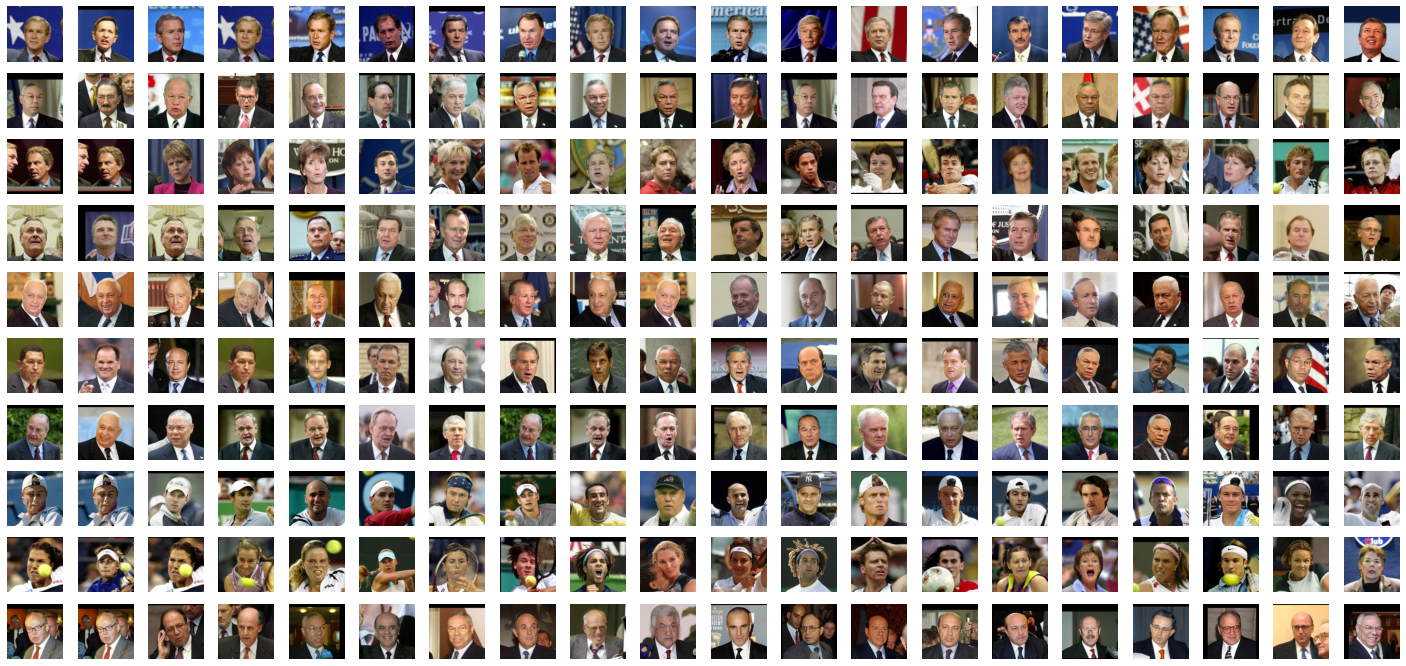

In [109]:
import numpy as np
plt.figure(figsize=(25,12))
x = 1
for n in range(10):
  plt.subplot(10,20,x) 
  plt.axis('off')
  x += 1
  plt.imshow(Image.open(img_10[n]))
  distance = []
  for f in feature_vector_space:
    distance.append(np.linalg.norm(img_feature[n] - f))
  distance = np.array(distance)
  for img in img_path[np.argpartition(distance, 19)[:19]]:
    plt.subplot(10,20,x) 
    x += 1
    plt.imshow(Image.open(input_path+'train/'+img))
    plt.axis('off')